In [1]:
import io
import requests

from PIL import Image as im

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:


oid = 'ZTF18acevrat'

r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': oid,
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_magpsf = pd.read_json(io.BytesIO(r.content))



In [6]:
%pwd

'/Users/mohamadjouni/work/FAnomAlly/notebook'

In [7]:
pdf_magpsf#.to_parquet('test.parquet')

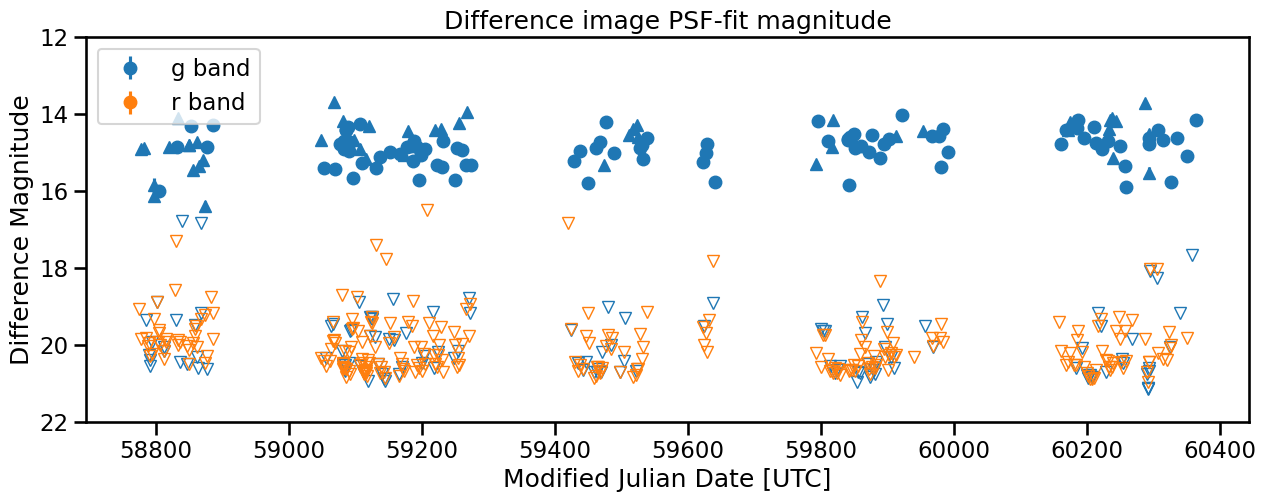

In [4]:


mjd = pdf_magpsf['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_magpsf['d:tag'] == 'valid'
    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf_magpsf['d:tag'] == 'upperlim'
    plt.plot(
        pdf_magpsf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf_magpsf['d:tag'] == 'badquality'
    plt.errorbar(
        pdf_magpsf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskBadquality & maskFilt]['i:magpsf'],
        pdf_magpsf[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



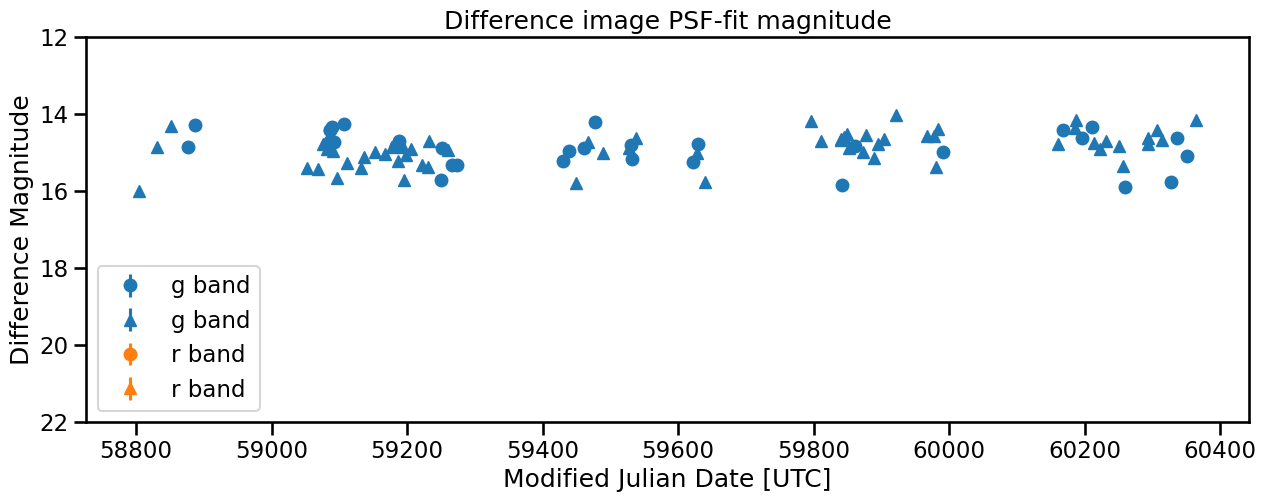

In [5]:

 
mjd = pdf_magpsf['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf['i:fid'] == filt
    # The column `d:tag` is used to check data type
    maskValid = pdf_magpsf['d:tag'] == 'valid' 
    maskneg = pdf_magpsf['i:isdiffpos'] == 't' 

    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    maskpos = pdf_magpsf['i:isdiffpos'] == 'f' 

    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:sigmapsf'],
        ls = '', marker='^', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    
    
    #pa pratique !
    maskUpper = pdf_magpsf['d:tag'] == 'upperlim'
    #plt.plot(pdf_magpsf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
    #pdf_magpsf[maskUpper & maskFilt]['i:diffmaglim'],ls='', marker='o', color=colordic[filt],  )

    maskBadquality = pdf_magpsf['d:tag'] == 'badquality'
    #plt.errorbar(
    #    pdf_magpsf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
    #    pdf_magpsf[maskBadquality & maskFilt]['i:magpsf'],
    #    pdf_magpsf[maskBadquality & maskFilt]['i:sigmapsf'],
    #    ls='', marker='o', color=colordic[filt])

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



In [6]:


# from fink_science.conversion import dc_mag
from fink_utils.photometry.conversion import dc_mag
from fink_utils.photometry.utils import is_source_behind

# Take only valid measurements
pdf_magpsf_valid = pdf_magpsf[pdf_magpsf['d:tag'] == 'valid'].sort_values('i:jd', ascending=False)

isSource = is_source_behind(
    pdf_magpsf_valid['i:distnr'].values[0]
)

if isSource:
    print('It looks like there is a source behind. Lets compute the DC magnitude instead.')
    
    # Use DC magnitude instead of difference mag
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_magpsf_valid['i:magpsf'].astype(float).values,
                pdf_magpsf_valid['i:sigmapsf'].astype(float).values,
                pdf_magpsf_valid['i:magnr'].astype(float).values,
                pdf_magpsf_valid['i:sigmagnr'].astype(float).values,
                pdf_magpsf_valid['i:isdiffpos'].values
            )
        ]
    )
    
    pdf_magpsf_valid['i:mag_dc'] = mag_dc
    pdf_magpsf_valid['i:err_dc'] = err_dc
else:
    print('No source found -- keeping PSF fit magnitude')
    pdf_magpsf_valid['i:mag_dc'] = pdf_magpsf_valid['i:magpsf']
    pdf_magpsf_valid['i:err_dc'] = pdf_magpsf_valid['i:sigmapsf']



It looks like there is a source behind. Lets compute the DC magnitude instead.


nan 13.046


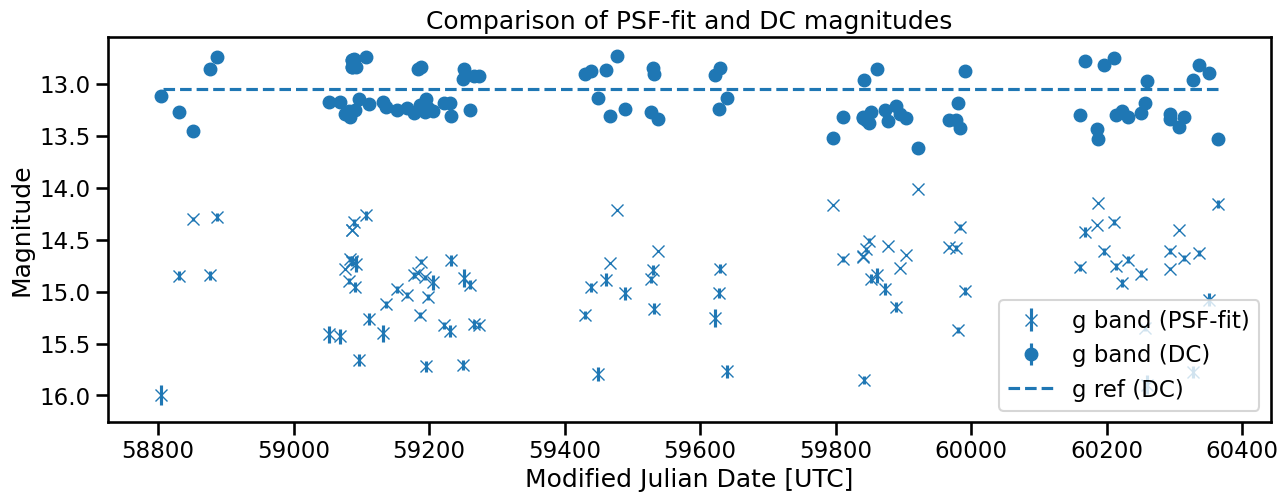

In [7]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt

    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magpsf'],
        pdf_magpsf_valid[maskFilt]['i:sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magnr'],
        ls = '--', 
        color=colordic[filt], 
        label='{} ref (DC)'.format(filtdic[filt]),
    )


ref_r = pdf_magpsf_valid['i:magnr']*(pdf_magpsf_valid['i:fid']==2)

ref_r = (ref_r[ref_r != 0]).mean()

ref_g = pdf_magpsf_valid['i:magnr']*(pdf_magpsf_valid['i:fid']==1)

ref_g = (ref_g[ref_g != 0]).mean()


print(ref_r, ref_g)

#plt.axhline(y=ref_r, color=colordic[2], linestyle='--')
#plt.axhline(y=ref_g, color=colordic[1], linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

nan


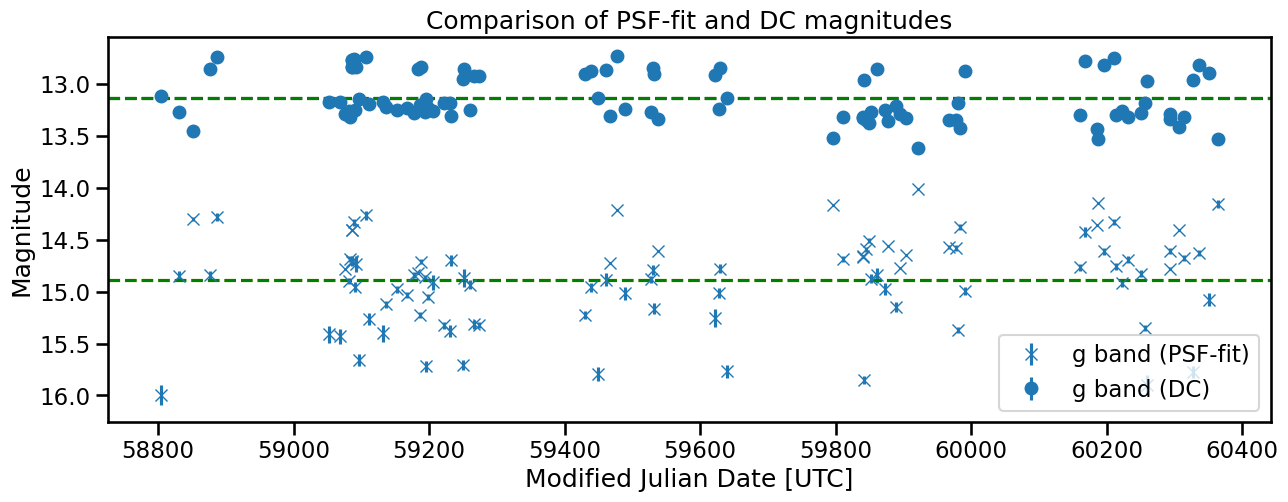

In [8]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}
moy_dc_1= 0  
for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    #moy_dc_1 += pdf_magpsf_valid[maskFilt]['i:mag_dc'].mean # * (maskFilt)

    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magpsf'],
        pdf_magpsf_valid[maskFilt]['i:sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )
lignes = pdf_magpsf_valid.shape



mean_dc = pdf_magpsf_valid['i:mag_dc'].mean()
mean_psf = pdf_magpsf_valid['i:magpsf'].mean()

mean_psf_r = (pdf_magpsf_valid['i:magpsf']*(pdf_magpsf_valid['i:fid']==2))
mean_psf_r = (mean_psf_r[mean_psf_r != 0]).mean()


mean_psf_g = (pdf_magpsf_valid['i:magpsf']*(pdf_magpsf_valid['i:fid']==1))
mean_psf_g = (mean_psf_g[mean_psf_g != 0]).mean()

mean_dc_r = (pdf_magpsf_valid['i:mag_dc']*(pdf_magpsf_valid['i:fid']==2))
mean_dc_r = (mean_dc_r[mean_dc_r != 0]).mean()


mean_dc_g = (pdf_magpsf_valid['i:mag_dc']*(pdf_magpsf_valid['i:fid']==1))
mean_dc_g = (mean_dc_g[mean_dc_g != 0]).mean()


print(mean_psf_r)
plt.axhline(y=mean_dc, color='k', linestyle='--')
plt.axhline(y=mean_psf, color='y', linestyle='--')
plt.axhline(y=mean_dc_r, color='r', linestyle='--')
plt.axhline(y=mean_dc_g, color='g', linestyle='--')

plt.axhline(y=mean_psf_r, color='r', linestyle='--')
plt.axhline(y=mean_psf_g, color='g', linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

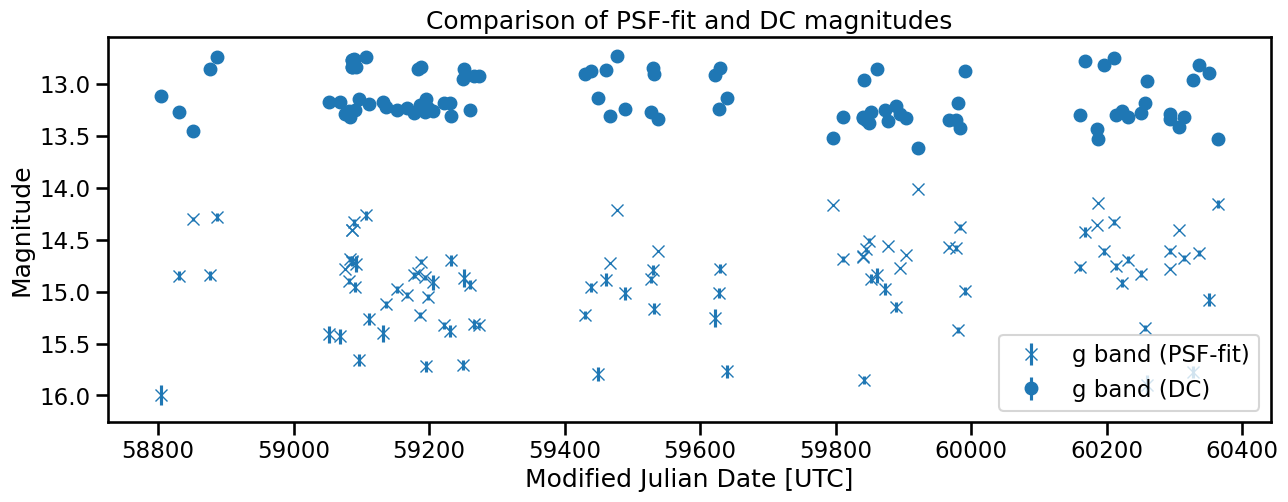

In [9]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt

    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magpsf'],
        pdf_magpsf_valid[maskFilt]['i:sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )

plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

